In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('BA_stock_data.csv') # doda zmodyfikowane RĘCZNIE dane z pliku

data = data[['Date','Close']]
#data

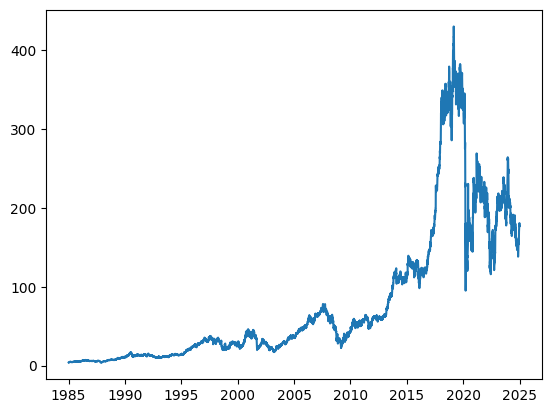

In [3]:
data['Date']=pd.to_datetime(data['Date'])
plt.plot(data['Date'],data['Close'])

In [4]:
from copy import deepcopy as dc

def prepare_dataframe(df,n_steps):
  df = dc(df)

  df.set_index('Date',inplace=True)
  # Create a list of shifted 'Close' columns
  shifted_columns = [df['Close'].shift(i).rename(f'Close(t-{i})') for i in range(1, n_steps+1)]
    
  # Concatenate all shifted columns with the original DataFrame
  df = pd.concat([df] + shifted_columns, axis=1)
  df.dropna(inplace=True)
  return df

lookback = 20
shifted_df = prepare_dataframe(data, lookback)
#shifted_df

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
shifted_df_as_np = shifted_df.to_numpy()
#shifted_df_as_np

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
#shifted_df_as_np

In [11]:
X = shifted_df_as_np[:,1:]
y = shifted_df_as_np[:,0]

X.shape, y.shape

((10060, 20), (10060,))

In [12]:
X = dc(np.flip(X, axis = 1))
#X


In [13]:
split_index = int(len(X)*0.95)
split_index

9557

In [14]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9557, 20), (503, 20), (9557,), (503,))

In [15]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_test = y_test.reshape((-1, 1))
y_train = y_train.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((9557, 20, 1), (503, 20, 1), (9557, 1), (503, 1))

In [16]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9557, 20, 1]),
 torch.Size([503, 20, 1]),
 torch.Size([9557, 1]),
 torch.Size([503, 1]))

In [17]:
from torch.utils.data import Dataset

class TimeSeries(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
  def __len__(self):
    return len(self.X)
  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeries(X_train, y_train)
test_dataset = TimeSeries(X_test, y_test)

In [18]:
train_dataset

In [19]:
from torch.utils.data import DataLoader
batch_size = 8 # mniej lepiej

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([8, 20, 1]) torch.Size([8, 1])


In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
model = LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss/ 100
            print('Batch: {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            
            
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val loss: {0:.3f}'.format(avg_loss_across_batches))
    print('****************************************************************')
    print()
        

In [24]:
learning_rate = 0.001
num_epochs = 25 # więcej lepiej
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch: 100, Loss: 0.282
Batch: 200, Loss: 0.114
Batch: 300, Loss: 0.094
Batch: 400, Loss: 0.050
Batch: 500, Loss: 0.037
Batch: 600, Loss: 0.026
Batch: 700, Loss: 0.016
Batch: 800, Loss: 0.013
Batch: 900, Loss: 0.007
Batch: 1000, Loss: 0.003
Batch: 1100, Loss: 0.004

Val loss: 0.002
****************************************************************

Epoch: 2
Batch: 100, Loss: 0.002
Batch: 200, Loss: 0.001
Batch: 300, Loss: 0.001
Batch: 400, Loss: 0.001
Batch: 500, Loss: 0.001
Batch: 600, Loss: 0.000
Batch: 700, Loss: 0.001
Batch: 800, Loss: 0.001
Batch: 900, Loss: 0.000
Batch: 1000, Loss: 0.001
Batch: 1100, Loss: 0.001

Val loss: 0.001
****************************************************************

Epoch: 3
Batch: 100, Loss: 0.001
Batch: 200, Loss: 0.001
Batch: 300, Loss: 0.000
Batch: 400, Loss: 0.000
Batch: 500, Loss: 0.001
Batch: 600, Loss: 0.000
Batch: 700, Loss: 0.000
Batch: 800, Loss: 0.000
Batch: 900, Loss: 0.001
Batch: 1000, Loss: 0.000
Batch: 1100, Loss: 0.000

Val loss

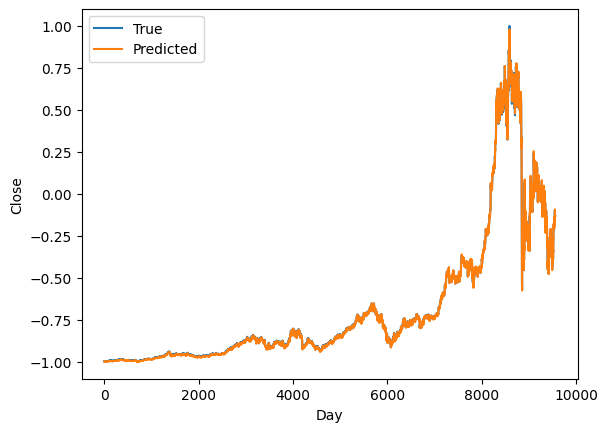

In [25]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
    
plt.plot(y_train, label='True')
plt.plot(predicted, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [26]:
train_predictions = predicted.flatten()


dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:,0])
train_predictions

array([-1.0001874 , -0.99996275, -0.99997497, ..., -0.13536277,
       -0.12906191, -0.13276517], shape=(9557,))

In [27]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

/var/folders/d7/80fz355j2730tx2lwyv6vf1w0000gn/T/ipykernel_94193/1256457756.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dummies[:,0] = y_train.flatten()


array([-0.99765253, -0.99773556, -0.9977771 , ..., -0.1300122 ,
       -0.13479675, -0.13231064], shape=(9557,))

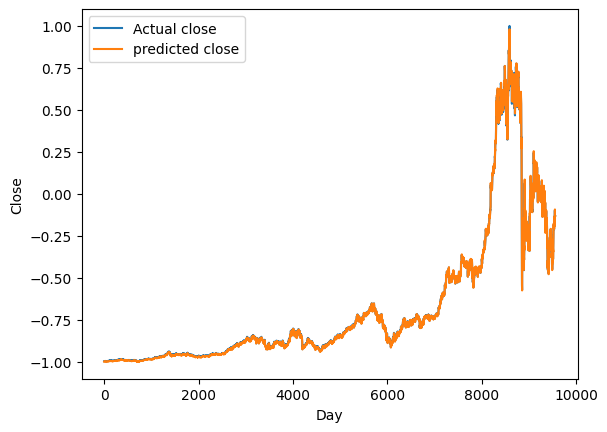

In [28]:
plt.plot(new_y_train, label='Actual close')
plt.plot(train_predictions, label='predicted close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [29]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummiies = np.zeros((X_test.shape[0], lookback+1))
dummiies[:,0] = test_predictions
dummiies = scaler.inverse_transform(dummiies)

test_predictions = dc(dummiies[:,0])
#test_predictions

In [30]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])
#new_y_test

/var/folders/d7/80fz355j2730tx2lwyv6vf1w0000gn/T/ipykernel_94193/2088832707.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dummies[:,0] = y_test.flatten()


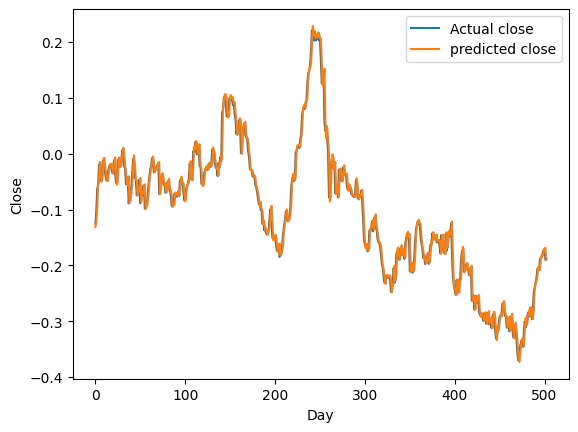

In [31]:
plt.plot(new_y_test, label='Actual close')
plt.plot(test_predictions, label='predicted close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()